In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import csv

**Logistic Regression**

This will deal with the problem of a binary classifier mapping inputs $x^{(i)}$ to one of two targets, $y^{(i)} = \{1,-1\}$ using the hypothesis $y^{(i)} = g(\theta^Tx^{(i)})$, where $g(z) = (1+e^{-z})^{-1}$. Note that, in this case, since $1-g(z) = g(-z)$ we can write the conditional probability as $P(y^{(i)}|x^{(i)},\theta) = g(y^{(i)}\theta^Tx^{(i)})$. This leads to a cost function (negative log-likelihood) of 

$J(\theta) = -\frac{1}{N}\sum log(g(y^{(i)}\theta^Tx^{(i)}))$, 

which we want to minimize using Newton's method.

Due to the property $g'(z) = g(z)(1-g(z))$, we have the gradient 

$\nabla_jJ = \frac{\partial J}{\partial \theta_j} = -\frac{1}{N}\sum g(-y^{(i)}\theta^Tx^{(i)})y^{(i)}x^{(i)}_j$,

and the Hessian

$H_{j,k} =  \frac{\partial^2 J}{\partial \theta_j\partial \theta_k} = \frac{1}{N}\sum g(-y^{(i)}\theta^Tx^{(i)})g(y^{(i)}\theta^Tx^{(i)})x^{(i)}_jx^{(i)}_k$,

where we note that $y^{(i)}$ has dropped out since $(y^{(i)})^2 = 1$.

To minimize this cost function, we will use Newton's algorithm. This means using the update rule $\theta := \theta-H^{-1}\nabla_jJ$ to converge to the point where the derivative is zero. Since this function is convex, we know this minimum is the global one.

First, we define the function which will perform Newton's method to update the weights:

In [2]:
def logisticRegression(features,targets,weights):
    """
    Inputs:
    features: NxM NumPy array of data features
    targets: NX1 NumPy array of targets
    weights: MX1 NumPy array of weights

    Output:
    Updates the weights for logistic regression 
    binary classification using Newton's algorithm,
    and returns the new value of the cost function J
    """
    margins = targets*np.dot(features,weights)
    N = np.shape(features)[0]
    sig = 1.0/(1+np.exp(margins))
    gradJ = -np.dot(features.T,targets*sig)/N
    hessJ = np.dot(features.T,np.dot(np.diagflat(sig*(1-sig)),features))/N
    weights -= np.dot(inv(hessJ),gradJ)
    newMargins = targets*np.dot(features,weights)
    newJ = np.sum(np.log(1+np.exp(-newMargins)))/N
    return newJ

Now, we'll read in the provided features (two variables per feature in this case, plus an additional variable equal to 1 added on for the intercept term), targets (list of +1, -1), and initialize the weights to zero.

In [3]:
features = np.array(list(csv.reader(open('logistic_x.txt','r'),delimiter=' ',quoting=csv.QUOTE_NONNUMERIC))) # Nx2 array
(nFeatures,nWeights) = np.shape(features) 
nWeights += 1
intercepts = np.ones((nFeatures,1)) # Nx1 array of ones
features = np.concatenate((intercepts,features),axis=1) # Nx3 array, first column is ones

In [4]:
targets = np.array(list(csv.reader(open('logistic_y.txt','r'),delimiter=' ',quoting=csv.QUOTE_NONNUMERIC)))

In [5]:
weights = np.zeros((nWeights,1))

Now, use our logistic regression function to iterate Newton's method. I'm going to be lazy here and just run for a ton of iterations rather than check for convergence, because it's fast.

In [6]:
for iterNum in range(1000):
    JVal = logisticRegression(features,targets,weights)

In [7]:
weights,JVal

(array([[-2.6205116 ],
        [ 0.76037154],
        [ 1.17194674]]), 0.329147431295712)

Okay, let's check that our answer has converged

In [8]:
JVal = logisticRegression(features,targets,weights)
weights,JVal

(array([[-2.6205116 ],
        [ 0.76037154],
        [ 1.17194674]]), 0.329147431295712)

Sweet. Now, let's use these weights to compute the hypothesis for each feature, and bin the results to be +1 or -1 (remember the hypothesis is technically continuous). Then, we'll plot the data, with a different symbol for each type. We should see a clear decision boundary between the two types if logistic regression was reasonable for this problem.

In [9]:
values = np.ndarray.flatten(1.0/(1+np.exp(-np.dot(features,weights))))

We'll plot the first feature variable on the x-axis, second on the y-axis, and split them into two sets based on the output values.

In [10]:
x1 = features[values>=0.5,1]
x2 = features[values<0.5,1]
y1 = features[values>=0.5,2]
y2 = features[values<0.5,2]
xBoundary = features[:,1]
yBoundary = -(weights[1]*xBoundary+weights[0])/weights[2]

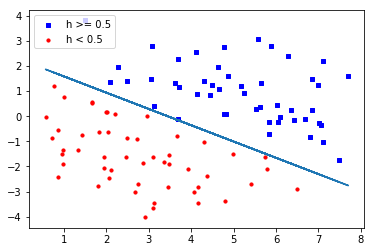

In [11]:
plt.scatter(x1,y1,s=10,c='b',marker="s",label='h >= 0.5')
plt.scatter(x2,y2,s=10,c='r',marker="o",label='h < 0.5')
plt.plot(xBoundary,yBoundary)
plt.legend(loc='upper left');
plt.show()

**Poisson Regression and the Exponential Family**

Note that the Poisson distribution can be written

$p(y;\lambda) = \frac{1}{y!}e^{-\lambda}\lambda^y = \frac{1}{y!}e^{log(\lambda)y-\lambda}$.

This clearly has the form of an exponential family distribution

$p(y;\eta) = b(y)e^{\eta T(y)-a(\eta)}$,

where $b(y) = \frac{1}{y!}$, $\eta = log(\lambda)$, $T(y) = y$, and $a(\eta) = e^\eta$. 

The canonical response function is defined as

$g(\eta) = E[T(y);\eta]$,

which in this case is merely the expectation value of $y$. Since the mean value of a Poisson distribution is $\lambda$, this yields

$g(\eta) = e^\eta$.

Now, the natural parameter $\eta$ is taken to be defined as $\eta = \theta^T x$. Consider the log-likelihood of a particular training example:

$\mathscr{L}(y^{(i)},\eta^{(i)}) = log(p(y^{(i)};\eta^{(i)} = log(b(y^{(i)}))+\eta^{(i)}T(y^{(i)})-a(\eta^{(i)})$.

We want the stochastic gradient ascent rule for one parameter $\theta_j$. Taking the derivative we find:

$\frac{\partial \mathscr{L}}{\partial \theta_j} = \frac{\partial \mathscr{L}}{\partial \eta^{(i)}} \frac{\partial \eta^{(i)}}{\partial \theta_j} = \left(T(y^{(i)})-\frac{\partial a}{\partial \eta^{(i)}}\right)x^{(i)}_j = \left(y^{(i)}-e^{\eta^{(i)}}\right)x^{(i)}_j$.

Thus, the stochastic gradient ascent rule is

$\theta_j := \theta_j+\alpha x^{(i)}_j \left(y^{(i)}-e^{\theta^T x^{(i)}}\right)$,

or more generically

$\theta_j := \theta_j+\alpha x^{(i)}_j \left(y^{(i)}-g(\eta^{(i)})\right)$.

Note that the last line is the valid expression for any generalized learning model where the probability distribution belongs to an exponential family.

**Regression for Denoising Quasar Spectra**

First we read in the training data. Format is an (N+1)xM array, where M is the number of distinct wavelengths, listed in row 0, and N is the number of intensity spectra we'll use to train. In this case, we have 450 wavelengths and 200 training examples.

In [25]:
quasarTrain = np.array(list(csv.reader(open('quasar_train.csv','r'),delimiter=',',quoting=csv.QUOTE_NONNUMERIC)))

In [26]:
(nTraining,nLambdas) = np.shape(quasarTrain)
nTraining -= 1

Now, consider a locally weighted linear least squares regression, with the cost function

$J(\theta) = \frac{1}{2}\sum w^{(i)} \left(\theta^T x^{(i)}-y^{(i)}\right)^2$.

Note that, if we define $X$ and $W$ such that $X_{ij} = x^{(i)}_j$ and $W_{ij} = \frac{1}{2}w^{(i)}\delta_{ij}$, so that we can write

$J(\theta) = \left(X\theta-y\right)^T W \left(X\theta-y\right)$.

We now want the derivative with respect to $\theta$.

$\begin{align*}
\nabla_\theta J & = \nabla_\theta \left(\theta^T X^T WX\theta-\theta^T X^T Wy-y^T WX\theta+y^T Wy\right) \\
& = \nabla_\theta \left(tr\left(\theta^T X^T WX\theta\right)-2tr\left(\theta y^T WX\right)\right).
\end{align*}$

Using the relation $\nabla_{A^T}tr\left(ABA^T C\right) = B^T A^T C^T+BA^T C$ with $A^T = \theta$, $B = X^T WX$ and $C = I$ and $\nabla_A tr\left(AB\right) = B^T$ with $A = \theta$ and $B = y^T WX$ we obtain

$\nabla_\theta J = 2 \left(X^T WX\theta-X^T Wy\right)$.

Setting the derivative to zero, we find

$\theta = \left(X^T WX\right)^{-1}X^T Wy$

Now, if we consider a normal distribution of errors where each training example has a distinct variance, the probability is

$p(y^{(i)}|x^{(i)};\theta) = \frac{1}{\sqrt{2\pi}\sigma^{(i)}}e^{-(y^{(i)}-\theta^T x^{(i)})^2/2(\sigma^{(i)})^2}$,

and thus the log-likelihood is

$\mathscr{L} = -\sum log\left(\sqrt{2\pi}\sigma^{(i)}\right)+\frac{1}{2(\sigma^{(i)})^2}\left(y^{(i)}-\theta^T x^{(i)}\right)^2$,

so that maximixing the likelihood is equivalent to minimizing 

$J(\theta) = \sum \frac{1}{2(\sigma^{(i)})^2}\left(y^{(i)}-\theta^T x^{(i)}\right)^2$,

which is a weighted least-squares regression with $w^{(i)} = (\sigma^{(i)})^{-2}$.

Now, let's perform unweighted linear regression on the first row of training data.

In [68]:
lambdas = quasarTrain[0:1,:].T
xVals = np.concatenate((np.ones((nLambdas,1)),lambdas),axis=1) # Nx2 array, first column is ones
yVals = quasarTrain[1:2,:].T
xMat = np.dot(xVals.T,xVals)
theta = np.dot(inv(xMat),np.dot(xVals.T,yVals))

In [69]:
theta

array([[  2.51339906e+00],
       [ -9.81122145e-04]])

In [70]:
fitLine = np.dot(xVals,theta)

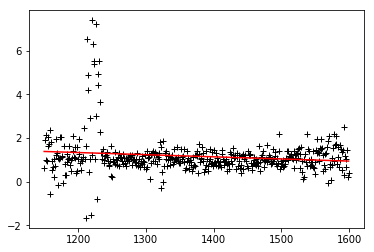

In [71]:
plt.plot(lambdas,yVals,'k+')
plt.plot(lambdas,fitLine,c='r')
plt.show()

In [116]:
fitLocalWeight = np.zeros((nLambdas,1))
tau = 5
for idx,x in enumerate(lambdas):
    w = np.exp(-(x-lambdas)**2/(2*tau**2))
    wMat = np.diagflat(w**2)
    xMat = np.dot(xVals.T,np.dot(wMat,xVals))
    yMat = np.dot(xVals.T,np.dot(wMat,yVals))
    thetaLocal = np.dot(inv(xMat),yMat)
    fitLocalWeight[idx] = np.dot([1,x],thetaLocal)

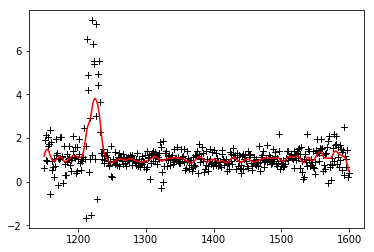

In [117]:
plt.plot(lambdas,yVals,'k+')
plt.plot(lambdas,fitLocalWeight,c='r')
plt.show()